In [ ]:
# https://cogcomp.seas.upenn.edu/Data/ER/conll04.corp

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from transformers import BertTokenizer
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# Constants
TRAIN_PATH = "../data/CoNLL04/train.txt"
DEV_PATH = "../data/CoNLL04/dev.txt"
TEST_PATH = "../data/CoNLL04/test.txt"
UNK_TOKEN = 100
CLS_TOKEN = 101
SEP_TOKEN = 102

In [4]:
entity_encode = {'O': 0, 'B-Loc': 1, 'I-Loc': 2, 'B-Peop': 3, 'I-Peop': 4, 
                 'B-Org': 5, 'I-Org': 6, 'B-Other': 7, 'I-Other': 8}
relation_encode = {'N': 0, 'Kill': 1, 'Located_In': 2, 'OrgBased_In': 3,
                   'Live_In': 4, 'Work_For': 5}

In [5]:
# Getters
def get_docs(group):
    """Read the dataset group and return a list of documents
    'group' is either "train", "dev", or "test"
    """
    dataset = None
    if group == "train":
        dataset = open(TRAIN_PATH, "r", encoding="utf8").readlines()
    elif group == "dev":
        dataset = open(DEV_PATH, "r", encoding="utf8").readlines()
    elif group == "test":
        dataset = open(TEST_PATH, "r", encoding="utf8").readlines()
    else:
        print("No '", group, "' data group found!")
        return []
    docs = []
    for line in dataset:
        if line.startswith("#"):
            docs.append([])
        docs[-1].append(line)
    return docs

In [6]:
def check_doc(document):
    """Check if the data in the document is consistent"""
    try:
        assert document[0].startswith("#doc ")
    except AssertionError:
        print("The document does not start with '#doc' but instead", document[0])
    doc_id = document[0].split()[1]
    for i in range(1, len(document)):
        line = document[i]
        try:
            assert int(line.split()[0]) == i - 1
        except (ValueError, AssertionError):
            print("Document", doc_id, "line", i, ":", line, "expect line index", 
                  i - 1, ", found", line.split()[0])

def check_docs(group):
    """Check if all the documents contained in the data group is consistent
    'group' is either "train", "dev", or "test"
    """
    docs = get_docs(group)
    for document in docs:
        check_doc(document)

In [7]:
def check_data():
    """Check if the everything in the dataset is consistent
    Refer to check_docs(group) and check_doc(document)
    """
    check_docs("train")
    check_docs("dev")
    check_docs("test")

In [8]:
# check_data()

In [9]:
def describe_list(lst, name):
    """Show the properties of the given sequence"""
    print("Description of", name, ":")
    print("Count:", len(lst))
    print("Sum:", sum(lst))
    print("Min:", min(lst))
    print("Mean:", sum(lst) / len(lst))
    print("Max:", max(lst))
    sns.distplot(lst, axlabel=name)
    plt.show()
    print()

In [10]:
def get_text_length_doc(document):
    """Get the length of a document"""
    return len(document) - 1

In [11]:
def describe_text_length(group):
    """Show information about the length of documents in the dataset group"""
    lengths = []
    docs = get_docs(group)
    for document in docs:
        lengths.append(get_text_length_doc(document))
    describe_list(lengths, "document lengths of " + group)

In [12]:
# describe_text_length("train")
# describe_text_length("dev")
# describe_text_length("test")

In [13]:
def split_line(line):
    """Split a line in the following format from the dataset
    index word entity_type ['relation_type_1', ...] ['target_entity_1', ...]
    """
    index, word, entity_type, rest = tuple(line.split(maxsplit=3))
    rt, te = tuple(rest.split("]", 1))
    relation_types = [item.strip("\r\n\t []'") for item in rt.split(",")]
    target_entities = [int(item.strip("\r\n\t []'")) for item in te.split(",")]
    assert len(relation_types) == len(target_entities)
    return index, word, entity_type, relation_types, target_entities

In [14]:
def count_entity_doc(document):
    """Count the number of each type of entity in a document"""
    count = {}
    for line in document[1:]:
        _, _, entity_type, _, _ = split_line(line)
        if entity_type in count:
            count[entity_type] += 1
        else:
            count[entity_type] = 1
    return count

In [15]:
def count_relation_doc(document):
    """Count the number of each type of entity in a document"""
    count = {}
    for line in document[1:]:
        _, _, _, relation_types, _ = split_line(line)
        for relation in relation_types:
            if relation in count:
                count[relation] += 1
            else:
                count[relation] = 1
    return count

In [16]:
def describe_type(group, type_counter, describe=True):
    """Describe the types of a property in the dataset"""
    docs = get_docs(group)
    count = {}
    for document in docs:
        cnt = type_counter(document)
        for key in cnt:
            if key not in count:
                count[key] = cnt[key]
            else:
                count[key] += cnt[key]
    if describe:
        print("Description of type in", group)
        print("Total:", sum(count.values()))
        for key in count:
            print(key, ":", count[key])
        sns.barplot(list(count.values()), list(count.keys()))
        plt.show()
    # Return a map from entities to corresponding encoding numbers
    return dict(zip(count.keys(), range(len(count))))

In [17]:
# entity_encode = describe_type("train", count_entity_doc)
# describe_type("dev", count_entity_doc)
# describe_type("test", count_entity_doc)

In [18]:
# relation_encode = describe_type("train", count_relation_doc)
# describe_type("dev", count_relation_doc)
# describe_type("test", count_relation_doc)

In [19]:
def describe_data():
    print("Description of train dataset:")
    describe_text_length("train")
    describe_type("train", count_entity_doc)
    describe_type("train", count_relation_doc)
    print("---------------------------------------------------------------------------------")
    print("Description of dev dataset:")
    describe_text_length("dev")
    describe_type("dev", count_entity_doc)
    describe_type("dev", count_relation_doc)
    print("---------------------------------------------------------------------------------")
    print("Description of test dataset:")
    describe_text_length("test")
    describe_type("test", count_entity_doc)
    describe_type("test", count_relation_doc)
    print("---------------------------------------------------------------------------------")

Description of train dataset:
Description of document lengths of train :
Count: 910
Sum: 26804
Min: 2
Mean: 29.454945054945053
Max: 113


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


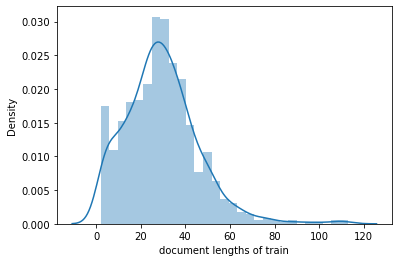


Description of type in train
Total: 26804
O : 20503
B-Loc : 1203
I-Loc : 621
B-Peop : 1145
I-Peop : 1206
B-Org : 595
I-Org : 714
B-Other : 448
I-Other : 369


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


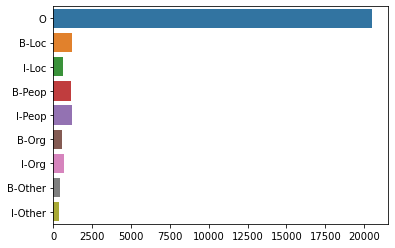

Description of type in train
Total: 26959
N : 25686
Located_In : 245
Work_For : 242
Live_In : 342
OrgBased_In : 241
Kill : 203


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


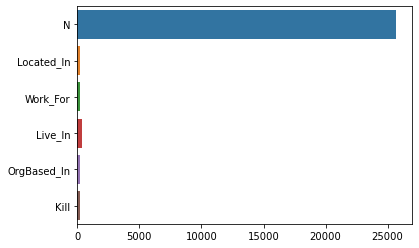

---------------------------------------------------------------------------------
Description of dev dataset:
Description of document lengths of dev :
Count: 243
Sum: 6975
Min: 2
Mean: 28.703703703703702
Max: 114


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


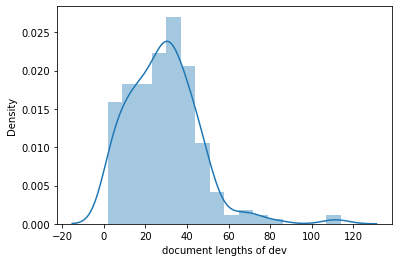


Description of type in dev
Total: 6975
O : 5355
B-Peop : 225
I-Peop : 231
B-Org : 190
I-Org : 241
B-Loc : 337
I-Loc : 124
B-Other : 125
I-Other : 147


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


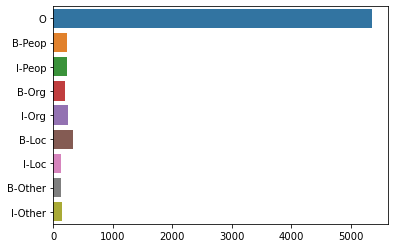

Description of type in dev
Total: 7019
N : 6666
Work_For : 83
Live_In : 79
Located_In : 67
OrgBased_In : 106
Kill : 18


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


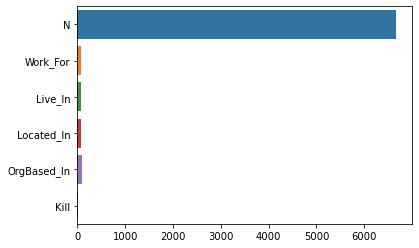

---------------------------------------------------------------------------------
Description of test dataset:
Description of document lengths of test :
Count: 288
Sum: 8408
Min: 2
Mean: 29.194444444444443
Max: 119


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


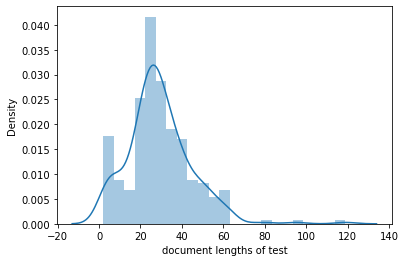


Description of type in test
Total: 8408
O : 6384
B-Other : 133
B-Org : 198
I-Org : 241
B-Loc : 427
B-Peop : 321
I-Peop : 369
I-Other : 130
I-Loc : 205


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


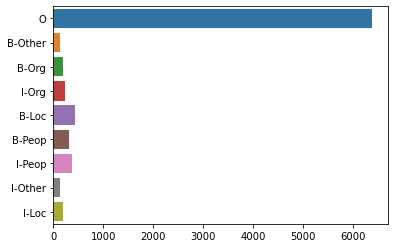

Description of type in test
Total: 8462
N : 8040
Kill : 47
Located_In : 94
OrgBased_In : 105
Live_In : 100
Work_For : 76


C:\Users\Public\Anaconda3\envs\work\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


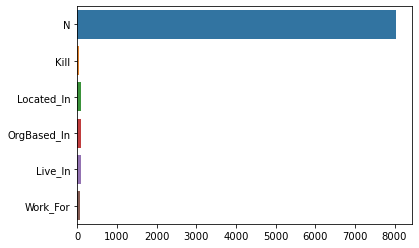

---------------------------------------------------------------------------------


In [20]:
describe_data()

In [21]:
def get_token_id(words):
    """Tokenize each word in a list of words
    Return a list of lists of token ids
    """
    token_id = []
    for word in words:
        # apply [1:-1] to remore CLS and SEP token ids at the begin and the end of the list
        token_id.append(tokenizer(word)["input_ids"][1:-1])
    return token_id

In [22]:
def expand_token_id(ids, token_ids, words, entity_embedding, entity_position):
    """Expand token id and duplicate members in other list wherever necessary"""
    # Test if all lists have the same length as expected
    try:
        assert len(ids) == len(token_ids) == len(words) == len(entity_embedding)
    except AssertionError:
        print("Input lists do not have the same length, abort")
        return ids, token_ids, words, entity_embedding, entity_position
    new_ids = []
    new_token_ids = []
    new_words = []
    new_entity_embedding = []
    id_range = {}
    last = 0
    for i in range(len(ids)):
        for tid in token_ids[i]:
            new_ids.append(ids[i])
            new_token_ids.append(tid)
            new_words.append(words[i])
            new_entity_embedding.append(entity_embedding[i])
        id_range[ids[i]] = (last, len(new_ids))
        last = len(new_ids)
    for key in entity_position:
        entity_position[key] = (id_range[entity_position[key][0]][0], 
                                id_range[entity_position[key][1]-1][1])
    return new_ids, new_token_ids, new_words, new_entity_embedding, entity_position

In [23]:
def extract_doc(document):
    """Extract data from a document"""
    doc_id = document[0].split()[1]
    index = []
    words = []
    entity_embedding = []
    entity_id = []
    relation_embedding = []
    target_entity_embedding = []
    entity_position = {}
    relations = {}
    entity_count = 0
    relation_count = 0
    # Parse the document
    for line in document[1:]:
        idx, word, entity_type, relation_types, target_entities = split_line(line)
        index.append(int(idx))
        words.append(word)
        entity_embedding.append(entity_encode[entity_type])
        relation_embedding.append(relation_types)
        target_entity_embedding.append(target_entities)
        if entity_type.startswith("B") or \
                (entity_type.startswith("I") and len(entity_embedding) >= 2 and entity_embedding[-2] == 0):
                # if an I appears after an O, assume it's the start of a new entity
            entity_count += 1
            entity_id.append(entity_count)
            entity_position[entity_count] = (int(idx), int(idx) + 1)
        elif entity_type.startswith("I"):
            entity_id.append(entity_count)
            entity_position[entity_count] = (entity_position[entity_count][0], int(idx) + 1)
        else:
            entity_id.append(0)
    # Parse the relations
    for idx in index:
        if "N" not in relation_embedding[int(idx)]:
            for relation, target in zip(relation_embedding[int(idx)], target_entity_embedding[int(idx)]):
                relation_count += 1
                relations[relation_count] = {"type": relation_encode[relation],
                                             "source": entity_id[int(idx)], 
                                             "target": entity_id[target]}
    # Tokenize and expand
    token_ids = get_token_id(words)
    data_frame = pd.DataFrame()
    data_frame["ids"], data_frame["token_ids"], data_frame["words"], data_frame["entity_embedding"], \
        entity_position = expand_token_id(index, token_ids, words, entity_embedding, entity_position)
    data_frame["tokens"] = tokenizer.convert_ids_to_tokens(data_frame["token_ids"]) 
    return {"document": doc_id,
            "data_frame": data_frame,
            "entity_position": entity_position,
            "relations": relations}

In [24]:
docs = get_docs("train")
extract_doc(docs[0])["document"]

'1024'

In [25]:
extract_doc(docs[0])["data_frame"]

,ids,token_ids,words,entity_embedding,tokens
0,0,2200,Very,0,very
1,1,2844,strong,0,strong
2,2,2148,south,0,south
3,3,7266,winds,0,winds
4,4,5642,accompanied,0,accompanied
5,5,1996,the,0,the
6,6,4040,storm,0,storm
7,7,2291,system,0,system
8,8,1010,",",0,","
9,9,2007,with,0,with


In [26]:
extract_doc(docs[0])["entity_position"]

{1: (21, 23), 2: (24, 27), 3: (28, 30)}

In [27]:
extract_doc(docs[0])["relations"]

{1: {'type': 2, 'source': 1, 'target': 3},
 2: {'type': 2, 'source': 2, 'target': 3}}

In [28]:
def extract_data(group):
    """Extract all documents to a dataset"""
    docs = get_docs(group)
    data = []
    for document in docs:
        data.append(extract_doc(document))
    return data

In [29]:
def check_extracted_data(data):
    """Check if all extracted data is valid"""
    for item in data:
        document_name = item["document"]
        data_frame = item["data_frame"]
        entity_position = item["entity_position"]
        relations = item["relations"]

        # Check if entities correctly embedded
        entity_embedding = data_frame["entity_embedding"].tolist()
        cnt = 0
        for entity_key in entity_position:
            low, high = entity_position[entity_key]
            cnt += high - low
            if high == low:
                print("Check failed at document", document_name, "in 'entity_embedding', key", entity_key, 
                      "is empty (from", low, "to", high, ")")
            else:
                try:
                    assert abs(min(entity_embedding[low:high]) - max(entity_embedding[low:high])) <= 1
                except AssertionError:
                    print("Check failed at document", document_name, "in 'entity_embedding', key", entity_key,
                          ", values from", low, "to", high, ":", entity_embedding[low:high], "are inconsistent")
        try:
            assert cnt == (np.array(entity_embedding) != 0).astype(int).sum()
        except AssertionError:
            print("Check failed at document", document_name, "in total entity embedded tokens",
                  (np.array(entity_embedding) != 0).astype(int).sum(), "does not match the record", cnt)

        # Check if all relations are valid
        for value in relations.values():
            first = value["source"]
            second = value["target"]
            try:
                assert first in entity_position
            except AssertionError:
                print("Check failed at document", document_name, "in 'relations',", first,
                      "is not found in record")
            try:
                assert second in entity_position
            except AssertionError:
                print("Check failed at document", document_name, "in 'relations',", second,
                      "is not found in record")


In [30]:
data = extract_data("train") + extract_data("dev") + extract_data("test")

In [31]:
check_extracted_data(data)